In [16]:
import sys
import os
sys.path.append('..')
from lib.path import get_training_data_dir, get_predicted_labeled_water_path, get_displaceable_water_path, get_non_displaceable_water_path
from lib.pdb import filter_atoms_and_create_new_pdb
from data_loader.SingleDataLoader import SingleDataLoader
from data_loader.DoubleDataLoader import DoubleDataLoader
from models.LeNet import LeNet
from models.ResNet import ResNet, ResNet1
from lib.helper import get_latest_checkpoint
from tensorflow.keras.losses import BinaryCrossentropy
from custom_losses.dice import dice_loss, dice_coefficient
from tensorflow.keras.metrics import Recall, Precision, Accuracy, SpecificityAtSensitivity, AUC, F1Score
from sklearn.metrics import confusion_matrix


import numpy as np

In [2]:
DATA_TYPE1 = 'Protein'
# DATA_TYPE2 = 'Protein'
DATA_VOXEL_NUM = 10
CLASSIFYING_RULE = 'WaterClassifyingRuleSurface'
LIGAND_POCKET_DEFINER = 'LigandPocketDefinerOriginal'
LIGAND_VOXEL_NUM = 8
MODEL_NAME = 'ResNet1'
TRAINER_NAME = 'aug_train_90'
training_data_dir1 = get_training_data_dir(DATA_TYPE1, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)
# training_data_dir2 = get_training_data_dir(DATA_TYPE2, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)

data_dir = '../../data'
test_list = os.path.join(data_dir, 'test_list')
data_loader = SingleDataLoader(training_data_dir1)
# data_loader = DoubleDataLoader(training_data_dir1, training_data_dir2)
test_data, test_data_label = data_loader.load_data(test_list)

Error processing 2bys: No data found for 2bys
Error processing 2jke: No data found for 2jke
Error processing 2jkp: No data found for 2jkp
Error processing 2xp7: No data found for 2xp7
Error processing 2zq0: No data found for 2zq0
Error processing 3i4b: No data found for 3i4b
Error processing 4jn2: No data found for 4jn2
Error processing 4l50: No data found for 4l50
Error processing 4l51: No data found for 4l51
Error processing 4n9c: No data found for 4n9c
Error processing 4r0a: No data found for 4r0a
Error processing 4u0f: No data found for 4u0f
Error processing 5fsx: No data found for 5fsx
Error processing 5fsy: No data found for 5fsy
Error processing 2bys: No data found for 2bys
Error processing 2jke: No data found for 2jke
Error processing 2jkp: No data found for 2jkp
Error processing 2xp7: No data found for 2xp7
Error processing 2zq0: No data found for 2zq0
Error processing 3i4b: No data found for 3i4b
Error processing 4jn2: No data found for 4jn2
Error processing 4l50: No data fou

2024-06-16 10:53:43.629554: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
input_shape = (DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, test_data.shape[-1])
n_base = 8
learning_rate = 1e-4
metrics = ['accuracy', dice_coefficient, Recall(), Precision()]
BN = True

In [4]:
checkpoint_dir = f'../checkpoints/{DATA_TYPE1}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
# checkpoint_dir = f'../checkpoints/{DATA_TYPE1}_{DATA_TYPE2}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
model = ResNet1(n_base, input_shape, learning_rate, BinaryCrossentropy(), metrics, BN=BN)
model.load_weights(latest_checkpoint)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 21, 21, 21, 5)]      0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 21, 21, 21, 8)        1088      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 21, 21, 21, 8)        32        ['conv3d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 21, 21, 21, 8)        0         ['batch_normalization[0][0

In [5]:
prediction = model.predict(test_data)
prediction_values = prediction.reshape(prediction.shape[0])
predicted_label = prediction.round()


423/423 [==============================] - 3s 6ms/step


In [19]:
cm = confusion_matrix(test_data_label, predicted_label)

# 混同行列の要素を取り出す
tn, fp, fn, tp = cm.ravel()

# 結果を表示
print("Confusion Matrix:")
print(cm)
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")
negative_precision = tn / (tn + fn)
print(negative_precision)

Confusion Matrix:
[[4981 1516]
 [2090 4923]]
True Negative (TN): 4981
False Positive (FP): 1516
False Negative (FN): 2090
True Positive (TP): 4923
0.7044265309008627


In [6]:
recall = Recall()
recall.update_state(test_data_label, predicted_label)
recall_value = recall.result().numpy()

precision = Precision()
precision.update_state(test_data_label, predicted_label)
precision_value = precision.result().numpy()

accuracy = Accuracy()
accuracy.update_state(test_data_label, predicted_label)
accuracy_value = accuracy.result().numpy()

specificity = SpecificityAtSensitivity(recall_value)
specificity.update_state(test_data_label, predicted_label)
specificity_value = specificity.result().numpy()

auc = AUC()
auc.update_state(test_data_label, prediction_values)
auc_value = auc.result().numpy()


In [7]:
print({"recall": recall_value, "precision": precision_value, "accuracy": accuracy_value, "specificity": specificity_value, "dice_coefficient": dice_coefficient(test_data_label, predicted_label).numpy(), "auc": auc_value})

{'recall': 0.701982, 'precision': 0.7645597, 'accuracy': 0.7330866, 'specificity': 0.7666615, 'dice_coefficient': 0.7319557, 'auc': 0.8041111}


In [8]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(test_data_label, prediction_values)

In [9]:
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold_youden = thresholds[optimal_idx]
optimal_threshold_youden

0.52051145

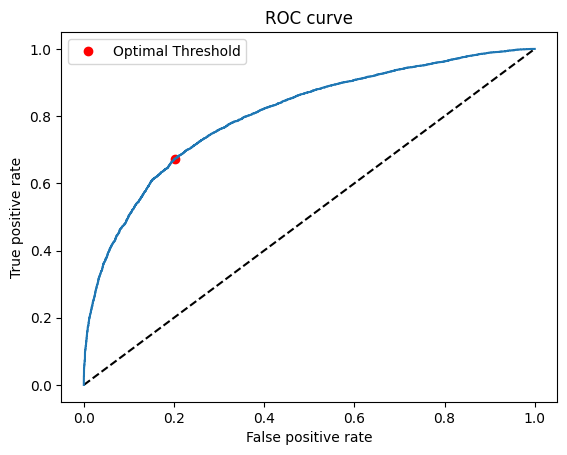

In [10]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label='Optimal Threshold')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [11]:
def custom_threshold(prediction, threshold):
    return (prediction > threshold).astype(int)
optimal_predicted_label = custom_threshold(prediction_values, optimal_threshold_youden)

In [12]:
recall = Recall()
recall.update_state(test_data_label, optimal_predicted_label)
optimal_recall_value = recall.result().numpy()

precision = Precision()
precision.update_state(test_data_label, optimal_predicted_label)
optimal_precision_value = precision.result().numpy()

accuracy = Accuracy()
accuracy.update_state(test_data_label, optimal_predicted_label)
optimal_accuracy_value = accuracy.result().numpy()

specificity = SpecificityAtSensitivity(optimal_recall_value)
specificity.update_state(test_data_label, optimal_predicted_label)
optimal_specificity_value = specificity.result().numpy()

auc = AUC()
auc.update_state(test_data_label, prediction_values)
auc_value = auc.result().numpy()


In [20]:
cm = confusion_matrix(test_data_label, optimal_predicted_label)

# 混同行列の要素を取り出す
tn, fp, fn, tp = cm.ravel()

# 結果を表示
print("Confusion Matrix:")
print(cm)
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")
negative_precision = tn / (tn + fn)
print(negative_precision)

Confusion Matrix:
[[5184 1313]
 [2290 4723]]
True Negative (TN): 5184
False Positive (FP): 1313
False Negative (FN): 2290
True Positive (TP): 4723
0.6936044955846936


In [13]:
print({"recall": optimal_recall_value, "precision": optimal_precision_value, "accuracy": optimal_accuracy_value, "specificity": optimal_specificity_value, "dice_coefficient": dice_coefficient(test_data_label, optimal_predicted_label).numpy(), "auc": auc_value})

{'recall': 0.6734636, 'precision': 0.78247184, 'accuracy': 0.7333087, 'specificity': 0.7979067, 'dice_coefficient': 0.72390807, 'auc': 0.8041111}
